[기초부터 시작하는 NLP: 문자 단위 RNN으로 이름 생성하기](https://tutorials.pytorch.kr/intermediate/char_rnn_generation_tutorial.html)

## 문자 단위 RNN 이름 생성

언어로 이름 생성하기

```bash
> python sample.py Russian RUS
Rovakov
Uantov
Shavakov

> python sample.py German GER
Gerren
Ereng
Rosher

> python sample.py Spanish SPA
Salla
Parer
Allan

> python sample.py Chinese CHI
Chan
Hang
Iun
```

## 데이터 준비

[데이터 다운로드](https://download.pytorch.org/tutorial/data.zip)

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open

import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,''-"
n_letters = len(all_letters) + 1 # EOS 추가

def findFiles(path): return glob.glob(path)

# 유니코드 문자열을 아스키로 변환
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 줄 단위로 분리
def readLines(filename):
    with open(filename, encoding='utf-8') as f:
        return [unicodeToAscii(line.strip()) for line in f]

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))
    


# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


## 네트워크 생성

지난 RNN이 다른 입력들과 연결되는 __category tensor__ 를 추가 인자로 가지도록 확장\
__category tensor__ 는 문자 입력과 마찬가지로 one-hot 벡터이다\
-> 입력의 사이즈가 n_categories 만큼 커지게 된다

__출력을 다음 문자의 확률로 해석하게 된다__

* 네트워크 구조

![](https://i.imgur.com/jzVrf7f.png)

In [7]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_letters)

## 학습

In [11]:
# (category, line)의 무작위 쌍 얻는 함수
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 임의의 category, category 내의 임의의 이름
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [12]:
"""
학습 단어의 각 문자:
    네트워크의 입력: (언어, 현재 문자, 은닉 상태)
    네트워크의 출력: (다음 문자, 다음 은닉 상태)

각 단계마다 현재 문자에서 다음 문자를 예측하기 때문에 문자 쌍은 한줄 에서 연속된 문자 그룹

예)
    "ABCD<EOS>"
        => (《A》, 《B》), (《B》, 《C》), (《C》, 《D》), (《D》, 《EOS》)
"""

# category를 위한 One-hot 벡터
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 입력의 처음부터 마지막(EOS 제외)까지의 One-hot 행렬
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 목표를 위한 두번째 문자부터 마지막(EOS)까지의 LongTensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    
    # EOS 추가
    letter_indexes.append(n_letters - 1)
    return torch.LongTensor(letter_indexes)

In [13]:
# 무작위로 데이터 가져오기
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### 네트워크 학습

In [14]:
# 모든 단계에서 예측 수행하므로 모든 단계에서 손실 계산하기
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(
    category_tensor,
    input_line_tensor,
    target_line_tensor,
):
    # 차원 증가
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item() / input_line_tensor.size(0)

In [15]:
# 학습에 걸리는 시간 추적
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [16]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
    
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 8s (5000 5%) 2.8886
0m 17s (10000 10%) 3.1435
0m 26s (15000 15%) 3.3171
0m 34s (20000 20%) 2.9192
0m 42s (25000 25%) 2.6544
0m 51s (30000 30%) 2.1383
0m 59s (35000 35%) 2.2871
1m 8s (40000 40%) 2.3723
1m 16s (45000 45%) 2.4224
1m 25s (50000 50%) 2.2740
1m 33s (55000 55%) 2.6970
1m 42s (60000 60%) 1.7750
1m 50s (65000 65%) 2.6797
1m 59s (70000 70%) 1.6432
2m 7s (75000 75%) 2.1924
2m 16s (80000 80%) 1.1969
2m 24s (85000 85%) 1.9526
2m 33s (90000 90%) 1.8452
2m 41s (95000 95%) 1.8385
2m 50s (100000 100%) 2.1632


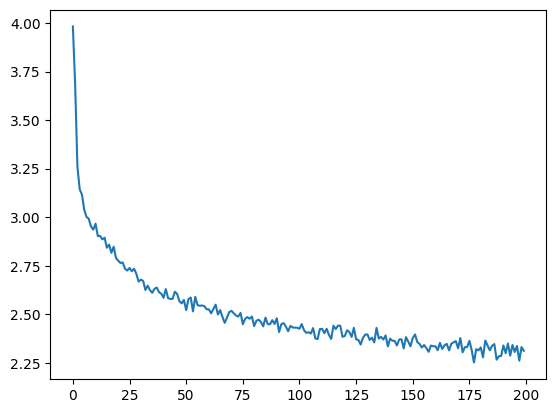

In [18]:
# 손실 도식화
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.show()

## 네트워크 샘플링

In [20]:
"""
샘플링을 위해, 네트워크에 하나의 글자를 주고 다음 문자를 물어본다
    그것을 다음 문자로 전달하는 것을 EOS토큰까지 반복한다

1. 입력 카테고리, 시작 문자, 비어 있는 은닉 상태를 위한 Tensor 생성하기
2. 시작 문자로 output_name 문자열 생성하기
3. 최대 출력 길이까지
    ㄴ 현재 문자를 네트워크에 전달
    ㄴ 가장 높은 출력에서 다음 문자 및 다음 은닉 상태 얻기
    ㄴ 문자가 EOS라면, 멈추기
    ㄴ 문자가 일반적인 문자라면, output_name에 추가하고 계속하기
4. 마지막 이름 반환하기
"""

max_length = 20

# 카테고리와 시작 문자로부터 샘플링
def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            _, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1: # EOS
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
        
        return output_name
    
# 하나의 카테고리, 여러 시작 문자들로 여러 샘플 얻기
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Roverin
Uarinov
Shilovev
Garren
Ererren
Roure
Saras
Perro
Arranoso
Chang
Hang
Iun
